# per Tissue Analysis and Models
*Ben Imlay*

## Database Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from pathlib import Path
from os import listdir
import sklearn.model_selection
import sklearn.feature_selection
%matplotlib inline
sns.set_style("darkgrid")

In [2]:
data_dir=Path("data")
tissue_dir=Path("tissue-specific")
manifest={"data":"All_Tissue_Site_Details.combined.reads.gct",
              "sample_meta":"GTEx_v7_Annotations_SampleAttributesDS.txt",
              "subject_meta":"GTEx_v7_Annotations_SubjectPhenotypesDS.txt",
               "merged_meta":"merged_meta.tsv"}
age_conversion={}
meta=pd.read_csv(data_dir/manifest['merged_meta'],sep="\t",dtype={'SMUBRID':object,'SEX':object,'DTHHRDY':object})
meta=meta[~(meta['AGE'].isnull())] # removes all samples without age
meta.iloc[0:3,:]

,SAMPID,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,...,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS,SUBJID,SEX,AGE,DTHHRDY
0,GTEX-1117F-0226-SM-5GZZ7,0.0,B1,"2 pieces, ~15% vessel stroma, rep delineated",6.8,Adipose Tissue,Adipose - Subcutaneous,0002190,1214.0,1125.0,...,50.094357,0.003102,0.992826,NaN,0.0,50.12628,GTEX-1117F,2.0,60-69,4.0
1,GTEX-111CU-1826-SM-5GZYN,0.0,B1,"2 pieces, small portion of nerve (<10% of one ...",7.5,Adipose Tissue,Adipose - Subcutaneous,0002190,138.0,571.0,...,50.089250,0.002126,0.993923,NaN,0.0,50.10142,GTEX-111CU,1.0,50-59,0.0
2,GTEX-111FC-0226-SM-5N9B8,2.0,B1,"2 pieces, larger piece is 30% fibrovascular ti...",7.3,Adipose Tissue,Adipose - Subcutaneous,0002190,1040.0,869.0,...,50.113018,0.003756,0.992825,NaN,0.0,50.06186,GTEX-111FC,1.0,60-69,1.0


## Avaiable Tissues

In [3]:
counts=pd.DataFrame(meta['SMTS'].value_counts())
display(counts)

,SMTS
Skin,1202
Esophagus,1021
Blood Vessel,913
Adipose Tissue,797
Heart,600
Muscle,564
Blood,537
Colon,507
Thyroid,446
Lung,427


This table shows that there are many tissues with >200 samples with age recorded. Only tissues with 200 samples or more will be considered for predictive analysis.

In [4]:
df=meta[meta['SMTS'].isin(counts[counts['SMTS']>200].index)]
df=pd.crosstab(index=df['SMTS'],columns=df['AGE'])
display(df)

AGE,20-29,30-39,40-49,50-59,60-69,70-79
SMTS,,,,,,
Adipose Tissue,57,66,131,273,245,25
Blood,50,46,103,169,163,6
Blood Vessel,75,75,160,310,273,20
Brain,12,8,36,112,152,11
Breast,26,32,53,88,81,10
Colon,45,48,95,164,140,15
Esophagus,102,91,191,356,258,23
Heart,33,29,95,220,205,18
Lung,27,30,76,145,139,10


In [5]:
TISSUE='Colon'
infiles=listdir(data_dir/tissue_dir)
TISSUE_files=[f for f in infiles if  TISSUE in f]
TISSUE_files
# Just need to confirm that they are all here

['Colon_c.tsv', 'Colon_lcpm.tsv', 'Colon_cpm.tsv']

## Reading CPM and LCPM files.

In [6]:
cpm=pd.read_csv(data_dir/tissue_dir/str(TISSUE+"_cpm.tsv"),sep="\t",index_col=0)
lcpm=pd.read_csv(data_dir/tissue_dir/str(TISSUE+"_lcpm.tsv"),sep="\t",index_col=0)
cdat=pd.read_csv(data_dir/tissue_dir/str(TISSUE+"_c.tsv"),sep="\t",index_col=0)

/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


,ENSG00000223972,ENSG00000227232,ENSG00000243485,ENSG00000237613,ENSG00000268020,ENSG00000240361
GTEX-111CU-1226-SM-5EGIN,0.037198,5.691331,0.018599,0.018599,0.037198,0.018599
GTEX-111YS-1826-SM-5GIEP,0.096569,6.006591,0.038628,0.019314,0.057941,0.019314
GTEX-1122O-1426-SM-5H11R,0.029172,8.868290,0.014586,0.000000,0.014586,0.029172
GTEX-117XS-2226-SM-5GIE1,0.056571,10.899255,0.018857,0.056571,0.037714,0.037714
GTEX-117YX-0526-SM-5EGJH,0.033939,5.854534,0.000000,0.033939,0.000000,0.016970


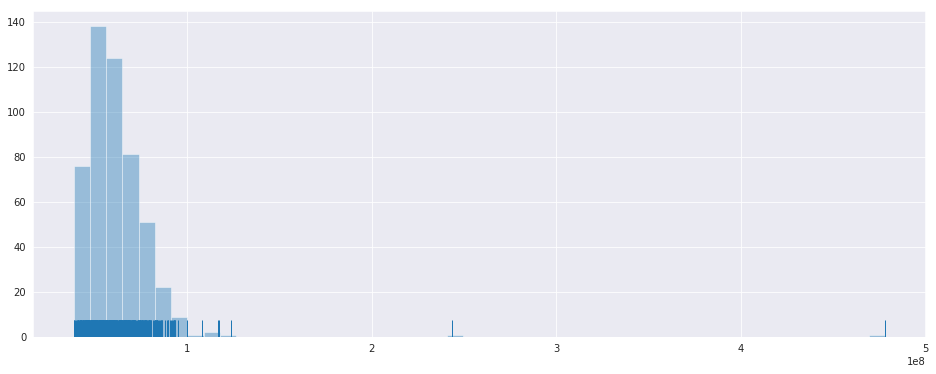

In [7]:
lib_size=np.sum(cdat,axis=1)
plt.figure(figsize=(16, 6))
sns.distplot(lib_size,kde=False,rug=True)
cpm.iloc[0:5,0:6]

In [8]:
lcpm.iloc[0:5,0:6]

,ENSG00000223972,ENSG00000227232,ENSG00000243485,ENSG00000237613,ENSG00000268020,ENSG00000240361
GTEX-111CU-1226-SM-5EGIN,-3.848209,2.516914,-4.298031,-4.298031,-3.848209,-4.298031
GTEX-111YS-1826-SM-5GIEP,-2.956740,2.594268,-3.818812,-4.277890,-3.471091,-4.277890
GTEX-1122O-1426-SM-5H11R,-4.025430,3.153890,-4.416670,-4.955184,-4.416670,-4.025430
GTEX-117XS-2226-SM-5GIE1,-3.493191,3.450418,-4.290735,-3.493191,-3.837539,-3.837539
GTEX-117YX-0526-SM-5EGJH,-3.917563,2.557476,-4.955184,-3.917563,-4.955184,-4.345032


### Merging metadata

In [9]:
tissue_meta=meta[(meta['SMTS']==TISSUE)]
tissue_meta.iloc[0:3]

,SAMPID,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,...,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS,SUBJID,SEX,AGE,DTHHRDY
4356,GTEX-111CU-1226-SM-5EGIN,1.0,B1,"6 pieces, well trimmed of mucosa",7.3,Colon,Colon - Sigmoid,0001159,91.0,618.0,...,50.321377,0.004702,0.994489,NaN,0.0,50.012290,GTEX-111CU,1.0,50-59,0.0
4357,GTEX-111YS-1826-SM-5GIEP,0.0,B1,6 pieces; muscularis (target) with up to 1 mm ...,7.8,Colon,Colon - Sigmoid,0001159,182.0,707.0,...,50.184856,0.006219,0.994353,NaN,0.0,50.037487,GTEX-111YS,1.0,60-69,0.0
4358,GTEX-1122O-1426-SM-5H11R,0.0,B1,"6 pieces, well trimmed",7.2,Colon,Colon - Sigmoid,0001159,106.0,897.0,...,50.095474,0.005570,0.994912,NaN,0.0,50.197144,GTEX-1122O,2.0,60-69,0.0


## Test and Train Set Creation

In [10]:
cdat_train, cdat_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(cdat, tissue_meta['AGE'], test_size=.3, random_state=1234)
cpm_train, cpm_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(cpm, tissue_meta['AGE'], test_size=.3, random_state=1234) # random state guarantees that the same split is made for a given tissue.
print(cpm_train.shape)
print(cpm_test.shape)
print(y_train.shape)
print(y_test.shape)
#GTEX-P78B-1326-SM-3P611 for reference for liver
print(cdat_train.index[0])
print(cpm_train.index[0]) # Confirms that two different calls to train_test_split on a different data set produce the same results
sum(cpm_train.iloc[:,0]) # Confirms that the split is the same each time

(354, 56202)
(153, 56202)
(354,)
(153,)
GTEX-14PHX-1126-SM-5YYA5
GTEX-14PHX-1126-SM-5YYA5


17.231292534812336

## Filter Lowly Expressed or Low Variance Genes
As adapted from the edgeR package function [filterByExpression](https://rdrr.io/bioc/edgeR/src/R/filterByExpr.R).

In [11]:
# Likely not possible in Python as cpm() is required
def filter_by_expr(counts,min_count=None,min_sample=None,grp=None):
    lib_size=np.sum(counts,axis=1)
    MedianLibSize=np.median(lib_size)
    norm_cutoff=min_count/MedianLibSize*1e6
    print(norm_cutoff)
    gene_counts=np.sum(counts)
#filter_by_expr(cpm_train)

### Filter by simple raw count threshold
Still as adapted from `filterByExpression`.

In [12]:
# Biased against samples with a smaller library size
def simpleExpressionFilter(counts,min_count):
    """accepts raw counts and a minimum sum count per gene across all samples
    return a boolean array of all genes, which can be applied to any transformed counts.
    True is associated with passing the test.
    """
    keep=np.sum(counts)>min_count
    print("Pre",counts.shape[1])
    filtered_counts=counts.loc[:,(keep)] # similar to how the boolean array would be used on any count matrix
    print("Post",filtered_counts.shape[1])
    return(keep)
keep_expr=simpleExpressionFilter(cdat_train,10)
cpm_train_expression_filter=cpm_train.loc[:,(keep_expr)]
cpm_test_expression_filter=cpm_test.loc[:,(keep_expr)]
print(cpm_test_expression_filter.shape) # confirming that both train and test set have undergone transformation identically
print(cpm_train_expression_filter.shape)

Pre 56202
Post 44995
(153, 44995)
(354, 44995)


### Filter by variance

In [13]:
selector=sklearn.feature_selection.VarianceThreshold(threshold=.1)
selector.fit(cpm_train_expression_filter)
var_keep=selector.get_support(indices=True)
train_final=cpm_train_expression_filter.iloc[:,var_keep]
test_final=cpm_test_expression_filter.iloc[:,var_keep]
print("Pre",cpm_train_expression_filter.shape[1])
print("Post",train_final.shape[1])

print(train_final.shape) # confirming that both train and test set have undergone transformation identically
print(test_final.shape)

Pre 44995
Post 18572
(354, 18572)
(153, 18572)


### Plotting mean distribution of genes after each processing step

/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


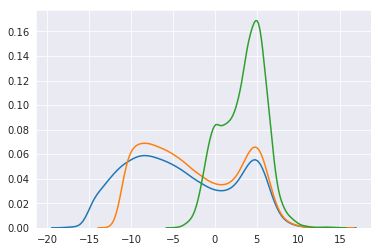

In [14]:
ax=sns.kdeplot(np.log2(np.mean(cpm_train,axis=0)))
ax=sns.kdeplot(np.log2(np.mean(cpm_train_expression_filter,axis=0)))
ax=sns.kdeplot(np.log2(np.mean(train_final,axis=0)))

## Training XGB model

In [15]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn import metrics #Additional scklearn functions

### Fitting function

In [21]:
def modelfit(alg, dtrain, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Only reports on self-validated predictions
    print("Internal Model Report")
    print( "Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print( "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
    
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)[:10]
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return (alg,feat_imp)

### Finalizing training data

In [17]:
predictors=train_final.columns
target='60-69'

train_age_encoding=pd.get_dummies(y_train.values)
test_age_encoding=pd.get_dummies(y_test.values)


dtrain=pd.concat([train_final.reset_index(drop=True),train_age_encoding[target]],axis=1)
dtrain=dtrain.set_index(cpm_train.index.values)
train_age_encoding.iloc[:3,:]

,20-29,30-39,40-49,50-59,60-69,70-79
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,0,1,0


### Define XGB1

Internal Model Report
Accuracy : 1
AUC Score (Train): 1.000000


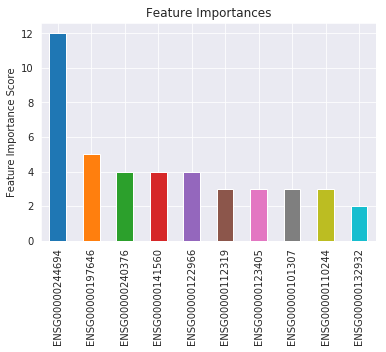

In [22]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=16,
 scale_pos_weight=1,
 seed=1234)
fit_xgb,feat_imp=modelfit(xgb1, dtrain, predictors, target)

## Test set validation

$$Precision=\frac{TP}{TP+FP}$$

$$Recall=\frac{TP}{TP+FN}$$

$$F1 = 2\times \frac{precision \times recall}{precision+recall}$$

In [23]:
y_test_target=test_age_encoding[target]
y_preds=fit_xgb.predict(test_final)
print(metrics.accuracy_score(y_test_target,y_preds))
print(metrics.f1_score(y_test_target,y_preds))

0.7647058823529411
0.4375


In [24]:
feat_imp

ENSG00000244694    12
ENSG00000197646     5
ENSG00000240376     4
ENSG00000141560     4
ENSG00000122966     4
ENSG00000112319     3
ENSG00000123405     3
ENSG00000101307     3
ENSG00000110244     3
ENSG00000132932     2
dtype: int64